### visualize the padded model

In [1]:
import torch
from transformers import GPT2LMHeadModel
model_path = "./final_model_padded" 

# 1. load model
model = GPT2LMHeadModel.from_pretrained(
    model_path, 
    attn_implementation="eager",
    output_attentions=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"Model reloaded successfully using the '{model.config._attn_implementation}' implementation.")
# 2. Re-create the character mapping (must match your training script exactly)
chars = sorted(list("0123456789+="))
char_to_id = {s: i for i, s in enumerate(chars)}
id_to_char = {i: s for i, s in enumerate(chars)}

# 3. Helper function needed for ablation and saliency
def decode_prediction(model, prompt, max_new=6):
    input_ids = torch.tensor([char_to_id[c] for c in prompt]).unsqueeze(0).to(model.device)
    with torch.no_grad():
        output_tokens = model.generate(input_ids, max_new_tokens=max_new, 
                                       pad_token_id=char_to_id['='], eos_token_id=char_to_id['='], 
                                       do_sample=False)
    gen_ids = output_tokens[0][len(input_ids[0]):]
    pred_str = "".join([id_to_char[tid.item()] for tid in gen_ids if id_to_char[tid.item()] in "0123456789"])
    return pred_str

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model reloaded successfully using the 'eager' implementation.


In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(model, text_input, layer_idx=0, head_idx=0):
    model.eval()
    # Ensure the model is configured to return attentions
    model.config.output_attentions = True 
    
    inputs = torch.tensor([char_to_id[c] for c in text_input]).unsqueeze(0).to(model.device)
    
    with torch.no_grad():
        outputs = model(inputs, output_attentions=True, return_dict=True)
    
    if outputs.attentions is None:
        print("Error: Model did not return attentions. Try reloading the model with output_attentions=True.")
        return

    # attentions is a tuple of length n_layers
    # Each element is (batch, num_heads, seq_len, seq_len)
    attention_matrix = outputs.attentions[layer_idx][0, head_idx].detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=list(text_input), yticklabels=list(text_input), 
                cmap="magma", annot=False)
    plt.title(f"Attention: Layer {layer_idx}, Head {head_idx}")
    plt.show()

# Example: visualize_attention(model, "123+456=975")

### for 00011+00022=33000

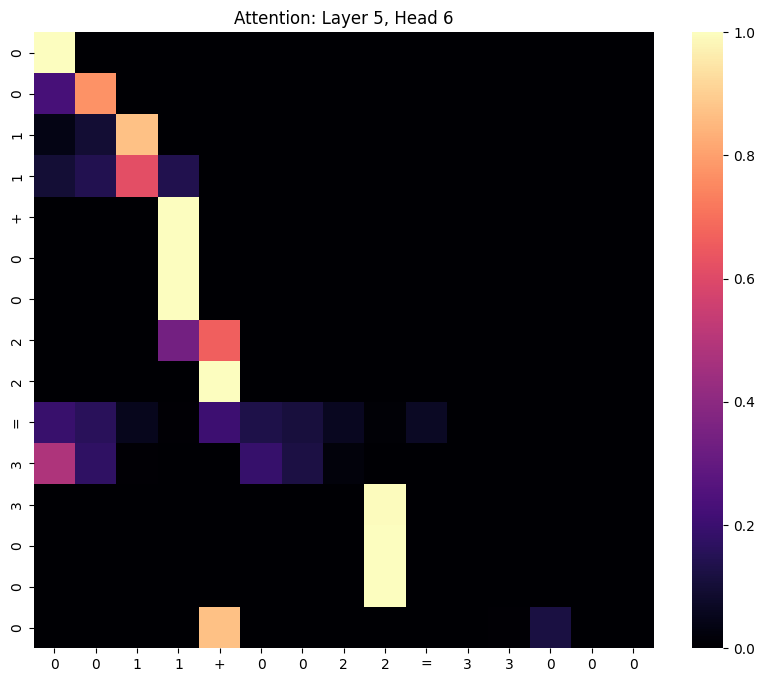

In [3]:
visualize_attention(model, "0011+0022=33000", layer_idx=5, head_idx=6)

### for 0001+0002=30000

ERROR! Session/line number was not unique in database. History logging moved to new session 26


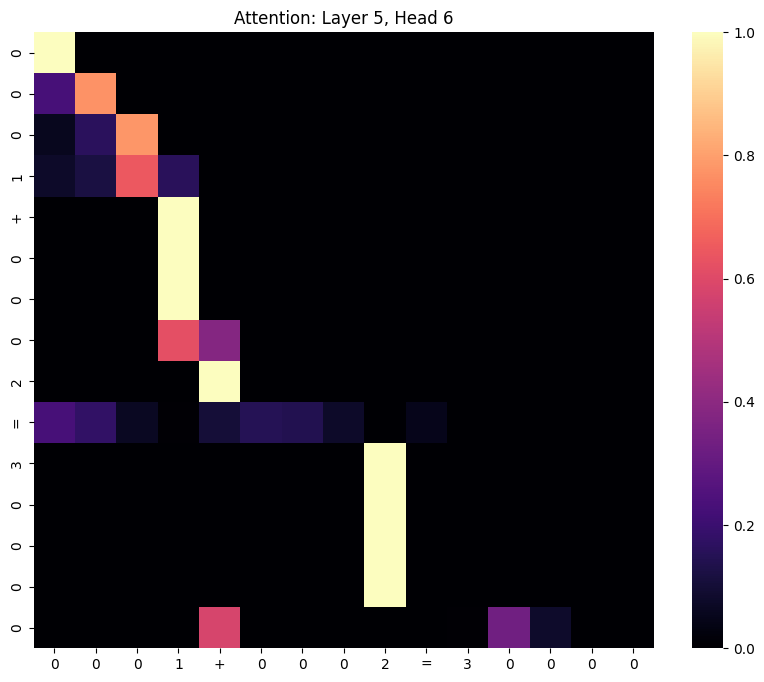

In [4]:
visualize_attention(model, "0001+0002=30000", layer_idx=5, head_idx=6)

### for 0101+0101=20200

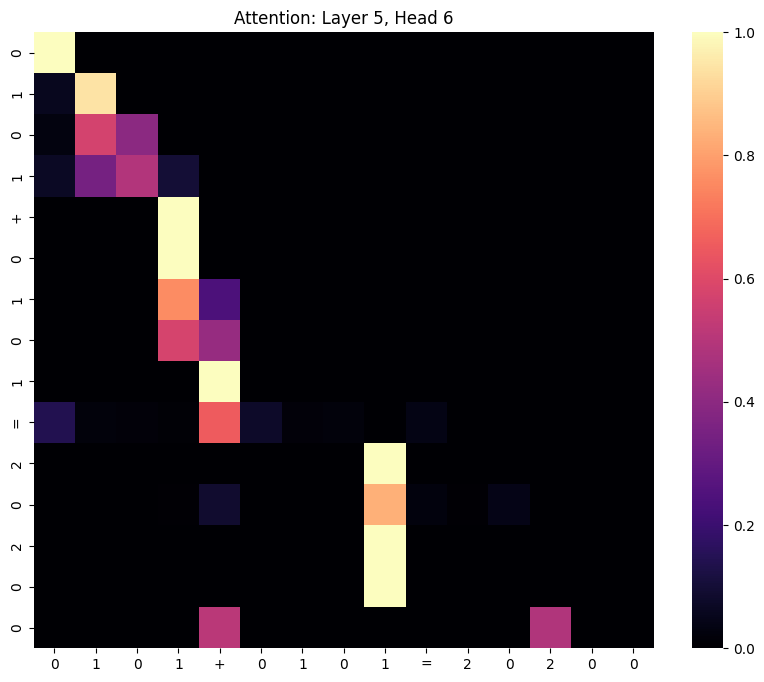

In [5]:
visualize_attention(model, "0101+0101=20200", layer_idx=5, head_idx=6)

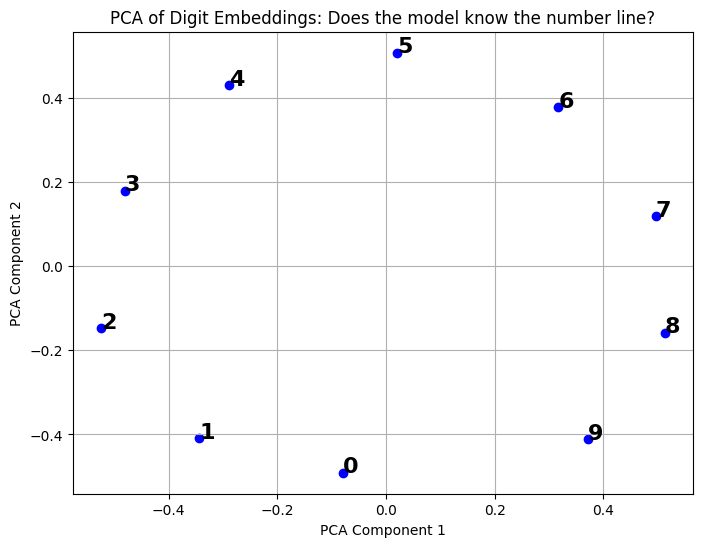

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_digit_pca(model):
    # Extract the token embedding table
    embeddings = model.transformer.wte.weight.detach().cpu().numpy()
    
    # Get embeddings for just '0' through '9'
    digit_tokens = [str(i) for i in range(10)]
    #print (digit_tokens)
    digit_ids = [char_to_id[d] for d in digit_tokens]
    #print (digit_ids)
    digit_embeds = embeddings[digit_ids]
    #print(digit_embeds)
    
    # Reduce to 2D
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(digit_embeds)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue')
    
    for i, txt in enumerate(digit_tokens):
        plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]), size=16, weight='bold')
        
    plt.title("PCA of Digit Embeddings: Does the model know the number line?")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

# To run:
plot_digit_pca(model)

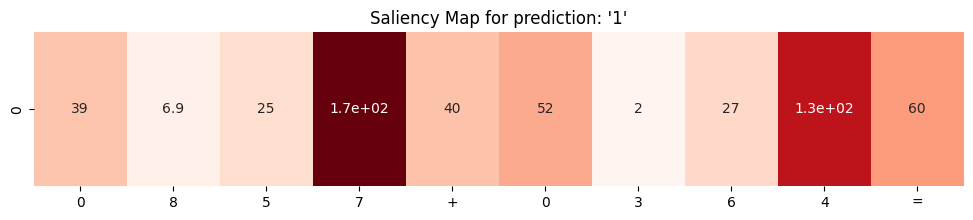

In [7]:
def plot_saliency_map(model, text_input):
    model.eval()
    # We need to compute gradients relative to the input embeddings
    input_ids = torch.tensor([char_to_id[c] for c in text_input]).unsqueeze(0).to(model.device)
    embeddings = model.transformer.wte(input_ids).clone().detach().requires_grad_(True)
    
    # Forward pass using embeddings directly
    # GPT2 accepts inputs_embeds instead of input_ids
    outputs = model(inputs_embeds=embeddings)
    
    # Let's look at the VERY LAST token prediction (the digit just generated)
    # We find the logit of the correct character
    logits = outputs.logits[0, -1, :]
    target_label = logits.argmax().item()
    
    # Backward pass to get gradients
    model.zero_grad()
    logits[target_label].backward()
    
    # Saliency is the magnitude of the gradient on the embeddings
    saliency = embeddings.grad.data.abs().sum(dim=-1).squeeze(0).cpu().numpy()
    
    plt.figure(figsize=(12, 2))
    sns.heatmap([saliency], xticklabels=list(text_input), annot=True, cmap="Reds", cbar=False)
    plt.title(f"Saliency Map for prediction: '{id_to_char[target_label]}'")
    plt.show()

# To run:
plot_saliency_map(model, "0857+0364=")

In [8]:
def find_critical_heads(model, test_samples):
    """
    Ablates each head one-by-one and measures the drop in Exact Match.
    """
    original_config = model.config.output_attentions
    model.config.output_attentions = False # Faster inference
    
    results = []
    num_layers = model.config.n_layer
    num_heads = model.config.n_head
    
    print(f"Scanning {num_layers * num_heads} heads...")
    
    for layer in range(num_layers):
        for head in range(num_heads):
            # 1. Hook to zero out this specific head
            def ablation_hook(module, input, output):
                # output is (batch, seq, embed_dim)
                # GPT2 attention output is (batch, seq, heads, head_dim)
                b, s, e = output.shape
                h_dim = e // num_heads
                output = output.view(b, s, num_heads, h_dim)
                output[:, :, head, :] = 0 # ZERO OUT THE HEAD
                return output.view(b, s, e)

            # 2. Attach hook
            handle = model.transformer.h[layer].attn.c_proj.register_forward_hook(ablation_hook)
            
            # 3. Test on a few samples
            correct = 0
            for prompt, expected in test_samples:
                pred = decode_prediction(model, prompt + "=")
                if pred == expected: correct += 1
            
            acc = correct / len(test_samples)
            results.append((layer, head, acc))
            
            # 4. Remove hook
            handle.remove()
            
    # Sort by lowest accuracy (most critical head)
    results.sort(key=lambda x: x[2])
    
    print("\n--- Top 3 Most Critical Heads ---")
    for l, h, acc in results[:3]:
        print(f"Layer {l}, Head {h} | Accuracy when removed: {acc:.2%}")

#To run (you'll need a list of (prompt, expected) tuples):
test_data = [("0123+0456", "97500"), ("0111+0222", "33300")] 
find_critical_heads(model, test_data)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Scanning 48 heads...

--- Top 3 Most Critical Heads ---
Layer 0, Head 0 | Accuracy when removed: 100.00%
Layer 0, Head 1 | Accuracy when removed: 100.00%
Layer 0, Head 2 | Accuracy when removed: 100.00%


In [9]:
import torch
from tqdm import tqdm

def run_layer_ablation_test(model, test_file, is_padded=True):
    """
    systematically disables one layer at a time to find the critical bottleneck.
    """
    model.eval()
    results = {}
    
    # Load test data
    test_samples = []
    with open(test_file, 'r') as f:
        for line in f:
            if line.strip():
                test_samples.append(line.strip().split('='))

    print(f"Starting Layer Ablation on {len(test_samples)} samples...")

    for layer_idx in range(model.config.n_layer):
        # 1. Define the Hook: It zeros out the hidden states but preserves the tuple structure
        def layer_zero_hook(module, input, output):
            # GPT2 layers return a tuple: (hidden_states, optional_presents, optional_attentions)
            if isinstance(output, tuple):
                hidden_states = output[0]
                # Zero out the entire hidden state tensor
                zeroed_hidden = torch.zeros_like(hidden_states)
                return (zeroed_hidden,) + output[1:]
            else:
                return torch.zeros_like(output)

        # 2. Register the hook to the entire Transformer Block
        # In GPT2, layers are stored in model.transformer.h
        handle = model.transformer.h[layer_idx].register_forward_hook(layer_zero_hook)

        # 3. Evaluate Accuracy
        correct = 0
        for prompt, expected in tqdm(test_samples[:200], desc=f"Testing Layer {layer_idx} disabled"):
            # Ensure we use the correct formatting (padded vs non-padded)
            predicted = decode_prediction(model, prompt + "=")
            if predicted == expected:
                correct += 1
        
        accuracy = (correct / min(len(test_samples), 200)) * 100
        results[layer_idx] = accuracy

        # 4. CRITICAL: Remove the hook before testing the next layer
        handle.remove()

    # Final Report Printing
    print("\n" + "="*30)
    print(" LAYER ABLATION RESULTS ")
    print("="*30)
    for layer, acc in results.items():
        impact = 100 - acc
        print(f"Layer {layer} Disabled: Accuracy {acc:6.2f}% | Impact: -{impact:6.2f}%")
    
    return results

# Run the test
layer_results = run_layer_ablation_test(model, "test_id_padded.txt")

Starting Layer Ablation on 1000 samples...


Testing Layer 5 disabled: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 292.81it/s]


 LAYER ABLATION RESULTS 
Layer 0 Disabled: Accuracy   0.00% | Impact: -100.00%
Layer 1 Disabled: Accuracy   0.00% | Impact: -100.00%
Layer 2 Disabled: Accuracy   0.00% | Impact: -100.00%
Layer 3 Disabled: Accuracy   0.00% | Impact: -100.00%
Layer 4 Disabled: Accuracy   0.00% | Impact: -100.00%
Layer 5 Disabled: Accuracy   0.00% | Impact: -100.00%
